In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vocab-d/dreaddit_vocab.txt
/kaggle/input/dreaddit/dreaddit-train.csv
/kaggle/input/dreaddit/dreaddit-test.csv


In [2]:
!pip install -q simpletransformers 

## Psychological Stress Classification Using Natural Language Processing & Deep Learning

### Abhay Puri & Sara Besharati

In [62]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from numpy.random import choice
import transformers
from gensim import downloader
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,StandardScaler
import os
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import warnings 
warnings.filterwarnings('ignore')

In [4]:
# Setup 
# Set seed for reproducibility
SEED = 1

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(SEED)

# if there is GPU available, use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

# Load the data
train = pd.read_csv('/kaggle/input/dreaddit/dreaddit-train.csv')
test = pd.read_csv('/kaggle/input/dreaddit/dreaddit-test.csv')

Using cuda device


In [5]:
def clear_cache():
    import gc
    gc.collect()

In [6]:
# Display the first 5 rows of the training data
train.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [7]:
# Display the first 5 rows of the test data
test.head()

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,896,relationships,7nu7as,"[50, 55]","Its like that, if you want or not.“ ME: I have...",0,0.8,1.514981e+09,22,-1.238793,...,1.0000,1.2000,1.0,1.65864,1.32245,1.80264,0.63,62,-0.148707,0.000000
1,19059,anxiety,680i6d,"(5, 10)",I man the front desk and my title is HR Custom...,0,1.0,1.493348e+09,5,7.684583,...,1.4000,1.1250,1.0,1.69133,1.69180,1.97249,1.00,2,7.398222,-0.065909
2,7977,ptsd,8eeu1t,"(5, 10)",We'd be saving so much money with this new hou...,1,1.0,1.524517e+09,10,2.360408,...,1.1429,1.0000,1.0,1.70974,1.52985,1.86108,1.00,8,3.149288,-0.036818
3,1214,ptsd,8d28vu,"[2, 7]","My ex used to shoot back with ""Do you want me ...",1,0.5,1.524018e+09,5,5.997000,...,1.0000,1.3000,1.0,1.72615,1.52000,1.84909,1.00,7,6.606000,-0.066667
4,1965,relationships,7r1e85,"[23, 28]",I haven’t said anything to him yet because I’m...,0,0.8,1.516200e+09,138,4.649418,...,1.1250,1.1429,1.0,1.75642,1.43582,1.91725,0.84,70,4.801869,0.141667


In [8]:
# shape of the training data and test data
print(f'The shape of the training data is {train.shape}')
print(f'The shape of the test data is {test.shape}')

The shape of the training data is (2838, 116)
The shape of the test data is (715, 116)


In [9]:
# info of the training data and test data
print(f'The info of the training data is {train.info()}')
print(f'The info of the test data is {test.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Columns: 116 entries, subreddit to sentiment
dtypes: float64(106), int64(6), object(4)
memory usage: 2.5+ MB
The info of the training data is None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Columns: 116 entries, id to sentiment
dtypes: float64(107), int64(5), object(4)
memory usage: 648.1+ KB
The info of the test data is None


In [10]:
# describe the training data 
train.describe()

,id,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
count,2838.000000,2838.000000,2838.000000,2.838000e+03,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,...,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000
mean,13751.999295,0.524313,0.808972,1.518107e+09,18.262156,4.684272,85.996124,35.240941,40.948231,67.044249,...,1.088001,1.120099,1.000211,1.722759,1.536400,1.879385,0.843517,9.948555,5.448836,0.040740
std,17340.161897,0.499497,0.177038,1.552209e+07,79.419166,3.316435,32.334887,26.486189,31.587117,32.880644,...,0.117159,0.085227,0.006500,0.047835,0.102971,0.058932,0.174794,21.798032,2.535829,0.195490
min,4.000000,0.000000,0.428571,1.483274e+09,0.000000,-6.620000,5.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.485400,1.200000,1.561150,0.140000,0.000000,-1.918000,-1.000000
25%,926.250000,0.000000,0.600000,1.509698e+09,2.000000,2.464243,65.000000,12.410000,12.135000,41.070000,...,1.000000,1.000000,1.000000,1.691430,1.469745,1.841782,0.750000,2.000000,3.729973,-0.072222
50%,1891.500000,1.000000,0.800000,1.517066e+09,5.000000,4.321886,81.000000,29.420000,33.520000,80.710000,...,1.000000,1.142900,1.000000,1.721430,1.530295,1.878250,0.890000,5.000000,5.210000,0.044821
75%,25473.750000,1.000000,1.000000,1.530898e+09,10.000000,6.505657,101.000000,55.057500,69.320000,96.180000,...,1.142900,1.142900,1.000000,1.751760,1.596030,1.916243,1.000000,10.000000,6.855217,0.166667
max,55757.000000,1.000000,1.000000,1.542592e+09,1435.000000,24.074231,310.000000,99.000000,99.000000,99.000000,...,1.900000,1.500000,1.200000,2.007400,2.066670,2.158490,1.000000,416.000000,21.198919,1.000000


In [11]:
# Number of posts in each subreddit
train.groupby('subreddit').count()

,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
subreddit,,,,,,,,,,,,,,,,,,,,,
almosthomeless,80,80,80,80,80,80,80,80,80,80,...,80,80,80,80,80,80,80,80,80,80
anxiety,503,503,503,503,503,503,503,503,503,503,...,503,503,503,503,503,503,503,503,503,503
assistance,289,289,289,289,289,289,289,289,289,289,...,289,289,289,289,289,289,289,289,289,289
domesticviolence,316,316,316,316,316,316,316,316,316,316,...,316,316,316,316,316,316,316,316,316,316
food_pantry,37,37,37,37,37,37,37,37,37,37,...,37,37,37,37,37,37,37,37,37,37
homeless,168,168,168,168,168,168,168,168,168,168,...,168,168,168,168,168,168,168,168,168,168
ptsd,584,584,584,584,584,584,584,584,584,584,...,584,584,584,584,584,584,584,584,584,584
relationships,552,552,552,552,552,552,552,552,552,552,...,552,552,552,552,552,552,552,552,552,552
stress,64,64,64,64,64,64,64,64,64,64,...,64,64,64,64,64,64,64,64,64,64


In [12]:
# Nan values
train.isnull().sum()

subreddit                   0
post_id                     0
sentence_range              0
text                        0
id                          0
                           ..
lex_dal_avg_pleasantness    0
social_upvote_ratio         0
social_num_comments         0
syntax_fk_grade             0
sentiment                   0
Length: 116, dtype: int64

Text(0, 0.5, 'Number of posts')

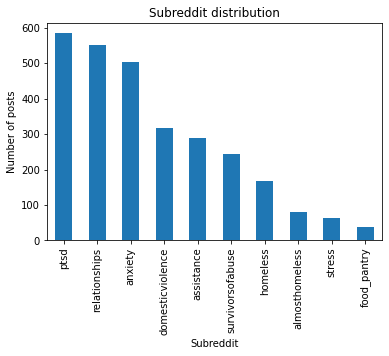

In [13]:
# label distribution
train['subreddit'].value_counts().plot(kind='bar')
# add title and axis names
plt.title('Subreddit distribution')
plt.xlabel('Subreddit')
plt.ylabel('Number of posts')


### Class Balance 
#### Label -----------> 1 (Stress)
#### Label -----------> 0 (Not stressed)

Text(0.5, 0, 'Label (0 - Not stress, 1 - Stress)')

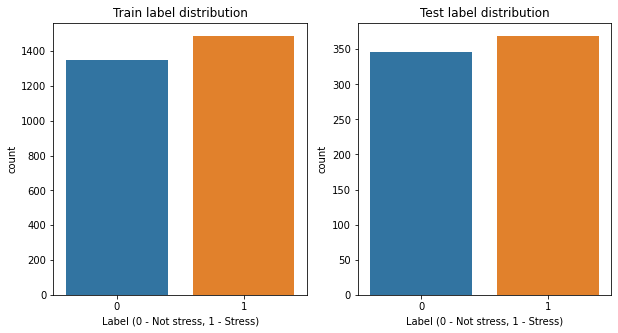

In [14]:
# Plotting the label distribution
# where 0 is no stress and 1 is stress
# In the paper it is mentioned that 52.3% posts are labeled as stress and 47.7% posts are labeled as no stress which matches with the plot below

# plot for both train and test label using seaborn
fig, axs = plt.subplots(1,2,figsize=(10,5))
sns.countplot(x='label', data=train, ax=axs[0])
axs[0].set_xlabel('Label (0 - Not stress, 1 - Stress)')
axs[0].set_title('Train label distribution')
sns.countplot(x='label', data=test, ax=axs[1])
axs[1].set_title('Test label distribution')
axs[1].set_xlabel('Label (0 - Not stress, 1 - Stress)')

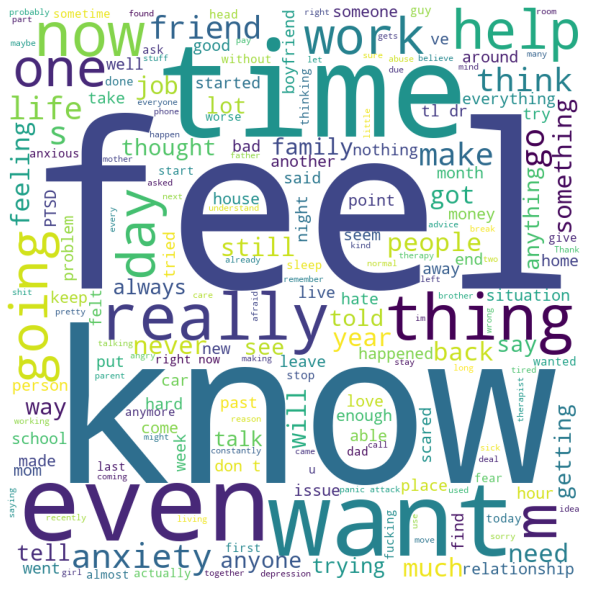

In [18]:
# most common words in stressed posts
stopwords = set(STOPWORDS)
stressed = train[train['label'] == 1]
stressed_words = ' '.join(stressed['text'])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(stressed_words)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

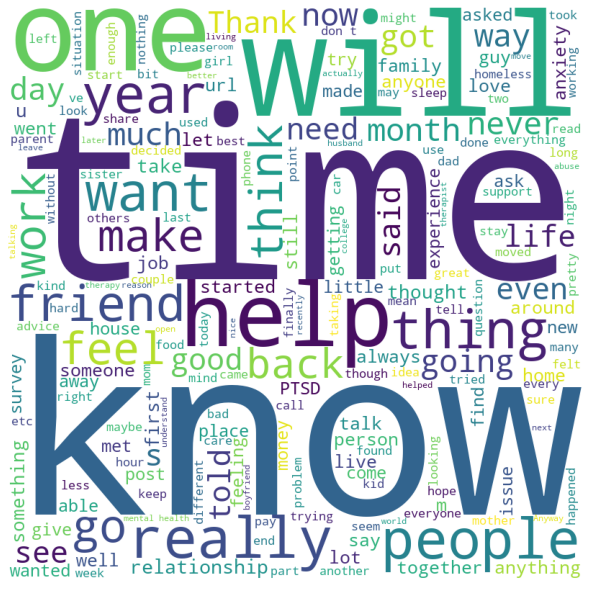

In [19]:
# most common words in non-stressed posts
stopwords = set(STOPWORDS)
not_stressed = train[train['label'] == 0]
not_stressed_words = ' '.join(not_stressed['text'])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(not_stressed_words)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Wordclouds are a great way to visualize the most common words in a text corpus.

Text(0, 0.5, 'Number of posts')

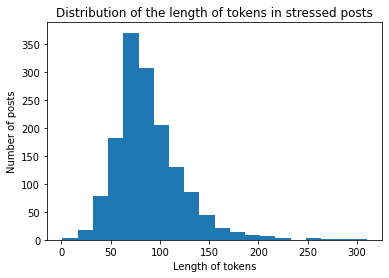

In [20]:
# Average length tokens in stressed posts
stressed['text'].apply(lambda x: len(x.split(' '))).mean()

# Average length tokens in non-stressed posts
non_stressed = train[train['label'] == 0]
non_stressed['text'].apply(lambda x: len(x.split(' '))).mean()

# Average length tokens in all posts
train['text'].apply(lambda x: len(x.split(' '))).mean()

# plot the distribution of the length of tokens in stressed posts
plt.hist(stressed['text'].apply(lambda x: len(x.split(' '))), bins=20)
plt.title('Distribution of the length of tokens in stressed posts')
plt.xlabel('Length of tokens')
plt.ylabel('Number of posts')

(array([  4.,  17.,  38.,  77., 232., 286., 233., 194., 107.,  63.,  44.,
         27.,  14.,   8.,   3.,   0.,   1.,   0.,   0.,   2.]),
 array([  1. ,  13.7,  26.4,  39.1,  51.8,  64.5,  77.2,  89.9, 102.6,
        115.3, 128. , 140.7, 153.4, 166.1, 178.8, 191.5, 204.2, 216.9,
        229.6, 242.3, 255. ]),
 <BarContainer object of 20 artists>)

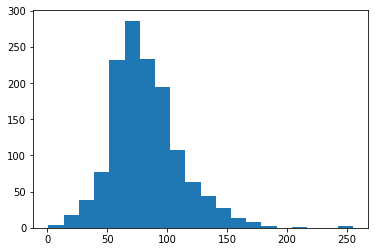

In [21]:
# plot the distribution of the length of tokens in non-stressed posts
plt.hist(non_stressed['text'].apply(lambda x: len(x.split(' '))), bins=20)


(array([  8.,  44., 153., 396., 735., 570., 401., 223., 147.,  73.,  38.,
         18.,  12.,   8.,   3.,   0.,   6.,   1.,   1.,   1.]),
 array([  1.  ,  16.45,  31.9 ,  47.35,  62.8 ,  78.25,  93.7 , 109.15,
        124.6 , 140.05, 155.5 , 170.95, 186.4 , 201.85, 217.3 , 232.75,
        248.2 , 263.65, 279.1 , 294.55, 310.  ]),
 <BarContainer object of 20 artists>)

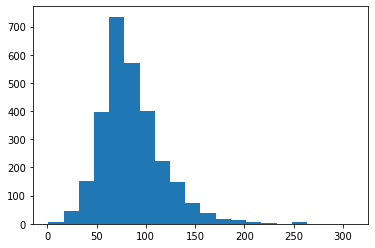

In [22]:
# plot the distribution of the length of tokens in all posts
plt.hist(train['text'].apply(lambda x: len(x.split(' '))), bins=20)


In [23]:
# Check the categorical variables in the training data and test data
print(f'The categorical variables in the training data are {train.select_dtypes(include="object").columns}')
print(f'The categorical variables in the test data are {test.select_dtypes(include="object").columns}')

The categorical variables in the training data are Index(['subreddit', 'post_id', 'sentence_range', 'text'], dtype='object')
The categorical variables in the test data are Index(['subreddit', 'post_id', 'sentence_range', 'text'], dtype='object')


### Feature Engineering

In [24]:
###### 1. Gender ratio
# pick female or male by the prior assumption of .40/.60 as mentioned in the paper
choice(2,10,p=[.4,.6]) #choose 10 samples from 2 classes with probability .4 and .6

# make a copy of the training data
gender_train_copy = train.copy()
# make a copy of the test data
gender_test_copy = test.copy()

gender_train_copy['Female'] = np.where(gender_train_copy['lex_liwc_female']>gender_train_copy['lex_liwc_male'], 1, 0)
gender_test_copy['Female'] = np.where(gender_test_copy['lex_liwc_female']>gender_test_copy['lex_liwc_male'], 1, 0)

print("Train:\n", gender_train_copy.Female.value_counts())
print("Test:\n", gender_test_copy.Female.value_counts())

Train:
 0    2127
1     711
Name: Female, dtype: int64
Test:
 0    533
1    182
Name: Female, dtype: int64


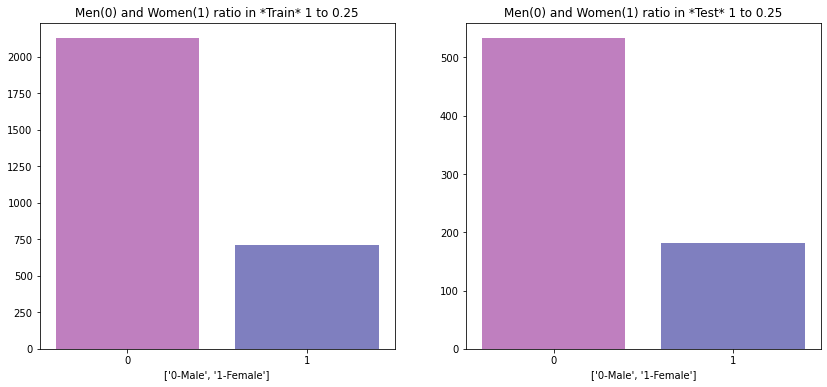

In [25]:
# have to change the code

f,axs = plt.subplots(1,2,figsize=(14,6))#,sharey=True)
trn=gender_train_copy.Female.value_counts()
male_trn = trn[0]
female_trn = trn[1]
female_pct_trn = female_trn/(male_trn+female_trn)
tst=gender_test_copy.Female.value_counts()
male_tst = tst[0]
female_tst = tst[1]
female_pct_tst = female_tst/(male_tst+female_tst)

axs[0].bar([0,1],[male_trn,female_trn],color=['purple','navy'],alpha=0.5)
axs[1].bar([0,1],[male_tst,female_tst],color=['purple','navy'],alpha=0.5)
axs[0].set_title('Men(0) and Women(1) ratio in *Train* 1 to {:.2f}'.format(female_pct_trn))
axs[1].set_title('Men(0) and Women(1) ratio in *Test* 1 to {:.2f}'.format(female_pct_tst))
axs[0].set_xlabel(['0-Male','1-Female'])
axs[1].set_xlabel(['0-Male','1-Female'])
axs[0].set_xticks([0,1])
axs[1].set_xticks([0,1])
plt.show()

In [26]:
##### 2. Post text length
##### The Dreaddit paper reported the average length of posts around 100 words. We will use this as a benchmark to see if the length of posts is a good indicator of stress. We will also use the standard deviation of the length of posts as a feature.

bert_tok = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

def find_max_len(tokenizer, texts, percent, c):
    max_len = 0
    max_len_lst = []

    for text in tqdm(texts):
        # step 1 tokenize the text
        tokens = tokenizer.tokenize(text)
        # Step 2: convert tokens to ids
        tokens_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_length = len(tokens_ids)
        max_len_lst.append(input_length)

    max_len = int(np.percentile(max_len_lst, percent)) + 1 # add 1 to make sure we are not cutting off any tokens
    avg_len = int(np.mean(max_len_lst)) + 1 
    print(c + f' max length: {max_len}')
    print(c + f' avg length: {avg_len}')
    return max_len, max_len_lst

max_len_train, max_len_lst_train = find_max_len(bert_tok, train.text, 99.9, 'Train')
max_len_test, max_len_lst_test = find_max_len(bert_tok, test.text, 99.9, 'Test')

print ("Train Max input length after tokenization {}".format(max_len_train))
print ("Test Max input length after tokenization {}".format(max_len_test))


100%|██████████| 2838/2838 [00:07<00:00, 389.06it/s]


Train max length: 333
Train avg length: 106


100%|██████████| 715/715 [00:01<00:00, 424.12it/s]

Test max length: 282
Test avg length: 105
Train Max input length after tokenization 333
Test Max input length after tokenization 282


Text(0, 0.5, 'Number of posts')

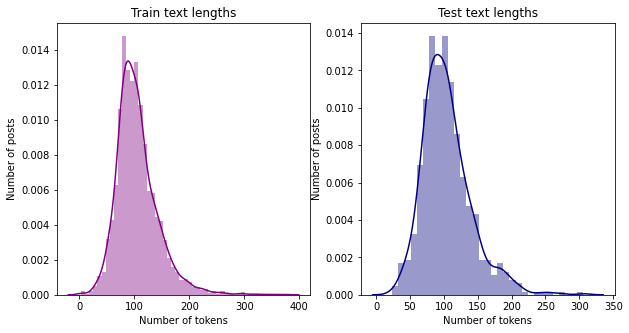

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# use seaborn to plot the distribution 
sns.distplot(max_len_lst_train, ax=axs[0], color='purple')
sns.distplot(max_len_lst_test, ax=axs[1], color='navy')

# set the title and labels
axs[0].set_title('Train text lengths')
axs[0].set_xlabel('Number of tokens')
axs[0].set_ylabel('Number of posts')
axs[1].set_title('Test text lengths')
axs[1].set_xlabel('Number of tokens')
axs[1].set_ylabel('Number of posts')

In [28]:
# adding text length as a feature to the original dataframe
train['text_len'] = max_len_lst_train
test['text_len'] = max_len_lst_test


#### Feature Selection
##### 1. As the paper mentioned we will only take with a high confidence score.(4/5)
##### 2. We will also analyzing the correlation of features to the label,  Pearson >= 0.5 will be selected as paper mentioned.

In [29]:
train = train.drop(['post_id', 'sentence_range', 'id'], axis = 1)
test = test.drop(['post_id', 'sentence_range', 'id'], axis = 1)

In [30]:
# Now we'll only taking 80% agreement or more (confidence level >= 0.8)
print(f'The number of posts in the training data before filtering is {train.shape[0]}')
print(f'The number of posts in the test data before filtering is {test.shape[0]}')

train = train[train['confidence'] >= 0.8]

print(f'The number of posts in the training data after filtering is {train.shape[0]}')
print(f'The number of posts in the test data after filtering is {test.shape[0]}')

The number of posts in the training data before filtering is 2838
The number of posts in the test data before filtering is 715
The number of posts in the training data after filtering is 1852
The number of posts in the test data after filtering is 715


In [31]:
df_train = pd.concat([train, test ], axis=0, ignore_index=True)
df_train.head()

,subreddit,text,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,...,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment,text_len
0,ptsd,"He said he had not felt that way before, sugge...",1,0.8,1.521614e+09,5,1.806818,116,72.64,15.04,...,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742,155
1,assistance,"Hey there r/assistance, Not sure if this is th...",0,1.0,1.527010e+09,4,9.429737,109,79.08,76.85,...,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857,132
2,ptsd,My mom then hit me with the newspaper and it s...,1,0.8,1.535936e+09,2,7.769821,167,33.80,76.38,...,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894,187
3,survivorsofabuse,October is Domestic Violence Awareness Month a...,1,0.8,1.539809e+09,24,7.554238,89,32.22,28.71,...,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167,106
4,relationships,I think he doesn't want to put in the effort f...,1,1.0,1.517274e+09,2,3.531124,105,28.22,46.19,...,1.1818,1.0,1.70415,1.44396,1.82046,0.75,5,4.338429,-0.550000,146


In [32]:
# One hot categorical variables
label_encoder = LabelEncoder()
df_train['subreddit'] = label_encoder.fit_transform(df_train['subreddit'])

df_train.head()


,subreddit,text,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,...,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment,text_len
0,6,"He said he had not felt that way before, sugge...",1,0.8,1.521614e+09,5,1.806818,116,72.64,15.04,...,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742,155
1,2,"Hey there r/assistance, Not sure if this is th...",0,1.0,1.527010e+09,4,9.429737,109,79.08,76.85,...,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857,132
2,6,My mom then hit me with the newspaper and it s...,1,0.8,1.535936e+09,2,7.769821,167,33.80,76.38,...,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894,187
3,9,October is Domestic Violence Awareness Month a...,1,0.8,1.539809e+09,24,7.554238,89,32.22,28.71,...,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167,106
4,7,I think he doesn't want to put in the effort f...,1,1.0,1.517274e+09,2,3.531124,105,28.22,46.19,...,1.1818,1.0,1.70415,1.44396,1.82046,0.75,5,4.338429,-0.550000,146


In [33]:
##### 1. As the paper mentioned they only reported the best results with only the features that have >= 0.4 pearson correlation with the label.
# check the highest correlation with the target
corr_features = df_train.corr().abs()['label'].sort_values(ascending = False)
#Taking only highest correlated features (paper's report |r|>=0.4)
corr_features = corr_features[corr_features >= 0.4]
corr_features



label              1.000000
lex_liwc_Tone      0.542968
lex_liwc_negemo    0.484842
lex_liwc_Clout     0.467876
lex_liwc_i         0.458949
Name: label, dtype: float64

In [35]:
##### 2 Tokenizers compared: BertTokenizer and Bert using Word2Vec vocabulary (Paper used it for best model)
VOCAB_FILE='/kaggle/input/vocab-d/dreaddit_vocab.txt'
def make_vocab_from_wv(wv, folder=None, special_tokens=None):
    words = wv.index_to_key
    if special_tokens is not None:
        to_add = []
        for special_token in special_tokens:
            if special_token not in words:
                to_add.append(special_token)
        words = to_add + words
                
    with open(os.path.join(folder, VOCAB_FILE), 'w') as f:
        for word in words:
            f.write(f'{word}\n') 

if(os.path.exists(VOCAB_FILE)):
    print('Using local vocab file:',VOCAB_FILE)
else:
    word2vec = downloader.load('word2vec-google-news-300')
    make_vocab_from_wv(word2vec, './', special_tokens=['[PAD]', '[UNK]'])

In [36]:
clear_cache()
w2v_tok = transformers.BertTokenizer(VOCAB_FILE)

In [37]:
def tokenize(tokenizer, texts):
    features = []
    for txt in tqdm(texts, desc = 'Tokenizing texts'):
        tokens = tokenizer.tokenize(txt)
        ids = tokenizer.convert_tokens_to_ids(tokens)
        features.append(ids)
    return features

In [38]:
df_train.columns = df_train.columns.astype(str)
features = ['text']+list(corr_features.index)

In [39]:
X,y = df_train[features], df_train['label']
bert_features = tokenize(w2v_tok, X['text'])

Tokenizing texts: 100%|██████████| 2567/2567 [00:06<00:00, 394.90it/s]


In [40]:
bert_trg = pad_sequences(bert_features, maxlen=max_len_train, padding='post', truncating='post')

In [41]:
X = pd.DataFrame(bert_trg)
X.columns = X.columns.astype(str)
ftrs = {}
for f in features:
    if(f in['text','label']):
        continue
    ftrs[f]=df_train[f].values
X = X.assign(**ftrs)  


In [ ]:
def plot_cm(y_true, y_pred, title, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)

Majority baseline classifier accuracy: 0.534
Majority baseline classifier f1: 0.697
Majority baseline classifier recall: 1.000
Majority baseline classifier precision: 0.534
Majority baseline classifier confusion matrix:


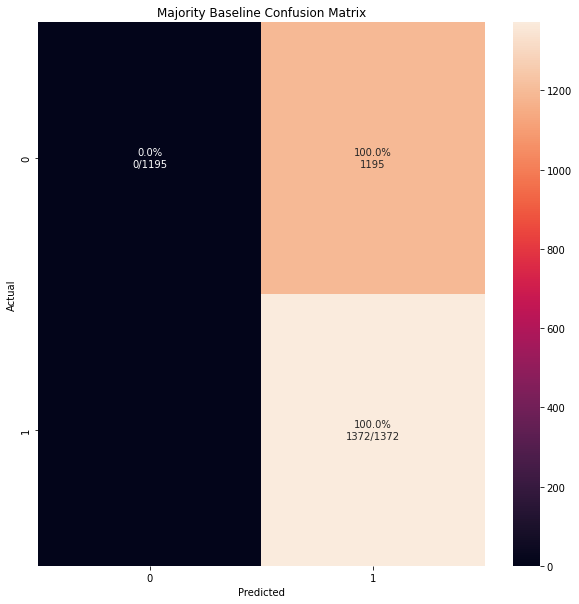

In [55]:
class MajorityBaselineClassifier():
    def __init__(self):
        self.majority_class = None
        
    def fit(self, X, y):
        self.majority_class = y.value_counts().idxmax()

    def predict(self, X):
        return [self.majority_class] * len(X)

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def f1_score(self, X, y):
        y_pred = self.predict(X)
        return f1_score(y, y_pred)

    def recall_score(self, X, y):
        y_pred = self.predict(X)
        return recall_score(y, y_pred)

    def precision_score(self, X, y):
        y_pred = self.predict(X)
        return precision_score(y, y_pred)

    def confusion_matrix(self, X, y):
        y_pred = self.predict(X)
        return confusion_matrix(y, y_pred)


# Majority baseline classifier
mbc = MajorityBaselineClassifier()
mbc.fit(X, y)
print('Majority baseline classifier accuracy: %.3f' % mbc.score(X, y))
print('Majority baseline classifier f1: %.3f' % mbc.f1_score(X, y))
print('Majority baseline classifier recall: %.3f' % mbc.recall_score(X, y))
print('Majority baseline classifier precision: %.3f' % mbc.precision_score(X, y))
# confusion matrix
print('Majority baseline classifier confusion matrix:')
plot_cm(y, mbc.predict(X),"Majority Baseline Confusion Matrix", figsize=(10,10))

In [64]:
def get_models():
    
    models = dict()
    models['LogReg'] = make_pipeline(StandardScaler(),LogisticRegression(solver = 'saga',
                                                                         C = 0.0001))
    models['MNNBayes'] = make_pipeline(MinMaxScaler(), MultinomialNB())
    models['SVM'] = make_pipeline(StandardScaler(),SVC())
    models['GBM'] = GradientBoostingClassifier(n_estimators = 10)
    models['ADAboost'] = AdaBoostClassifier(n_estimators= 12)
    models['XGBoost'] = XGBClassifier(n_estimators = 11, max_depth = 1)
    models['Dtree'] = DecisionTreeClassifier(max_depth = 1)
    models['Perceptron'] = make_pipeline(StandardScaler(),Perceptron())
    models['RandomF'] = RandomForestClassifier(n_estimators = 10)
    models['KNN'] = make_pipeline(StandardScaler(),KNeighborsClassifier())
    
    return models

# cross validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=SEED) #was 5
    scores = cross_validate(model, X, y, scoring=['f1','precision','recall'], cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [65]:
models = get_models()
results, names = list(), list()
best_score = 0
best_model = None
for name, model in models.items():
    print('Evaluating model:',name)
    scores = evaluate_model(model, X, y)
    names.append(name)
    f1_mean = scores['test_f1'].mean()
    f1_std  = scores['test_f1'].std()

    if(f1_mean>best_score):
        best_model = model
        best_name = name
        best_score = f1_mean
        precision_mean = scores['test_precision'].mean()
        recall_mean = scores['test_recall'].mean()
    results.append(f1_mean)
    print('>%s Avg.F1:%.3f F1-std:%.3f Avg.Precision:%.3f Avg.Recall:%.3f' % (name, f1_mean, f1_std,precision_mean,recall_mean))
print('Best classic ML model:<<<%s>>> Avg.F1:%.3f Avg.Precision:%.3f Avg.Recall:%.3f' % (best_name, best_score,precision_mean,recall_mean))

Evaluating model: LogReg
>LogReg Avg.F1:0.809 F1-std:0.013 Avg.Precision:0.758 Avg.Recall:0.868
Evaluating model: MNNBayes
>MNNBayes Avg.F1:0.787 F1-std:0.021 Avg.Precision:0.758 Avg.Recall:0.868
Evaluating model: SVM
>SVM Avg.F1:0.796 F1-std:0.020 Avg.Precision:0.758 Avg.Recall:0.868
Evaluating model: GBM
>GBM Avg.F1:0.800 F1-std:0.014 Avg.Precision:0.758 Avg.Recall:0.868
Evaluating model: ADAboost
>ADAboost Avg.F1:0.797 F1-std:0.018 Avg.Precision:0.758 Avg.Recall:0.868
Evaluating model: XGBoost
>XGBoost Avg.F1:0.795 F1-std:0.023 Avg.Precision:0.758 Avg.Recall:0.868
Evaluating model: Dtree
>Dtree Avg.F1:0.784 F1-std:0.016 Avg.Precision:0.758 Avg.Recall:0.868
Evaluating model: Perceptron
>Perceptron Avg.F1:0.726 F1-std:0.027 Avg.Precision:0.758 Avg.Recall:0.868
Evaluating model: RandomF
>RandomF Avg.F1:0.722 F1-std:0.025 Avg.Precision:0.758 Avg.Recall:0.868
Evaluating model: KNN
>KNN Avg.F1:0.732 F1-std:0.022 Avg.Precision:0.758 Avg.Recall:0.868
Best classic ML model:<<<LogReg>>> Avg.F

## Bert

In [66]:
!rm -rf cache_dir
!rm -rf outputs
!rm -rf runs

In [67]:
INFERENCE_MODE = False

In [1]:
import logging
logging.basicConfig(level=logging.ERROR)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.ERROR)

if(INFERENCE_MODE):
    print('Inference mode, loading best model...')
    !unzip -q -n {TRAINED_MODEL}
    model = ClassificationModel(
      "bert", "outputs/best_model",
      tokenizer_type=w2v_tok,
      use_cuda=torch.cuda.is_available()
    )
    print('Best model loaded.')
else:
    print('Training mode')
    model_args = ClassificationArgs(num_train_epochs=3,
                                  overwrite_output_dir = True,
                                  use_early_stopping = True,
                                  no_save = False,
                                  save_best_model=True,
                                  evaluate_during_training = True,
                                  evaluate_during_training_verbose=False,
                                  evaluate_during_training_silent=True,
    )
    model = ClassificationModel(
      "bert", "bert-base-uncased",tokenizer_type=w2v_tok,
      args=model_args,
      use_cuda=torch.cuda.is_available(),
    )
    model.train_model(df_train[['text','label']],eval_df=test[['text','label']])
    print('Training completed')
result, model_outputs, wrong_predictions = model.eval_model(test[['text','label']])

y_true_trn = df_train['label'].values
print('Train classification report')
y_pred_trn, _ = model.predict(list(df_train['text']))
print(classification_report(y_true_trn, y_pred_trn))



In [ ]:
y_true_tst = test['label'].values
print('Test classification report')
y_pred_tst, _ = model.predict(list(test['text']))

print(classification_report(y_true_tst, y_pred_tst))
f1_bert = f1_score(y_true_tst, y_pred_tst,average='weighted')s